In [1]:
# -*- coding: utf8 -*-
import os
import os.path
import datetime
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import squarify
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#import pickle

In [2]:
image_directory = "C:/Users/BF-MSTR/Google Drive/Wallpapers/"
# magick "C:\Users\BF-MSTR\Google Drive\Wallpapers\16\*.jpg" -resize 1000x1000 "C:\Users\BF-MSTR\Google Drive\Wallpapers\16\rs\rs_%03d.jpg"

In [ ]:
# DEBUG 
test_img = '1758 - Italy - Bernardo Bellotto - Das kaiserliche Lustchloss Schloss Hof, Ansicht von Norden.jpg'
np.shape(cv2.imread(os.path.join(image_directory, test_img)))
#cv2.imread(os.path.join(image_directory,test_img))
#os.path.join(image_directory,test_img)
#np.shape(cv2.imdecode(np.asarray(bytearray(open(os.path.join(image_directory, test_img), "rb").read()), dtype=np.uint8), cv2.IMREAD_UNCHANGED))

In [13]:
# Metadata 
year_labels = []
country_labels = []
artist_labels = []
artwork_labels = []
images_path = []
century_labels = []
file_format = []
width = []
height = []
aspect_ratio = []
density = []
image_date = []
#image = []

# List file paths
file_names = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
print('File names found: ', len(file_names))

# Clean up some problematic files
file_names.remove('desktop.ini') # System file
file_names.remove('.picasa.ini') # System file
file_names.remove('.dropbox') # System file
file_names.remove('1327 BC - Egypt - Unknown - The Pharaon Tutankhamun destroying his enemies.jpg') # BC year

# Some unindentified problem
file_names.remove('1758 - Italy - Bernardo Bellotto - Das kaiserliche Lustchloss Schloss Hof, Ansicht von Norden.jpg')
file_names.remove('1855 - United States - Frederic Edwin Church - Cotopaxi.jpg')

# Separator used to fetch metadata from name
sep = ' - '

File names found:  871


In [14]:
%%time

# Append metadata to lists
for f in file_names:
    print(f) # Help debugging
    images_path.append(os.path.join(image_directory,f))
    year_labels.append(f.split(sep)[0])
    country_labels.append(f.split(sep)[1])
    artist_labels.append(f.split(sep)[2])
    artwork_labels.append(f.split(sep)[3].split('.')[0])
    century_labels.append(pd.to_numeric(f.split(sep)[0][:2])+1)
    file_format.append(f.split('.')[1])
    ##h, w, d = np.shape(cv2.imread(os.path.join(image_directory,f)))
    h, w, d = np.shape(cv2.imdecode(np.asarray(bytearray(open(os.path.join(image_directory, f), "rb").read()), dtype=np.uint8), cv2.IMREAD_UNCHANGED))
    aspect_ratio.append(float(w) / float(h))
    width.append(w)
    height.append(h)
    density.append(d)
    image_date.append(time.strftime('%m/%d/%Y', time.gmtime(os.path.getmtime(os.path.join(image_directory,f)))))

1250 - Italy - Anonymous - Crucifixion with the Virgin and Saint John.jpg
1350 - Italy - Andrea di Cione Orcagna - Triptych with the Virgin and Child, and Saints Mary Magdalene and Ansanus.jpg
1400 - Netherlands - Anonymous - The Lords of Montfoort.jpg
1420 - Belgium - Jan van Eyck - The Crucifixion; The Last Judgement.jpg
1430 - Belgium - Jan van Eyck - Saint Francis of Assisi Receiving the Stigmata.jpg
1430 - Belgium - Jan van Eyck - The Ghent Altarpiece Open (center piece).jpg
1430 - Italy - Paolo Uccello - St Geoge slaying the dragon.jpg
1434 - Belgium - Jan van Eyck - The Arnolfini Portrait.jpg
1436 - Netherlands - Rogier van der Weyden - Pietà.jpg
1437 - Belgium - Jan van Eyck - Triptych of Mary and Child, St Michael and the Catherine.jpg
1438 - Italy - Paolo Uccello - Battle of San Romano (1).jpg
1438 - Italy - Paolo Uccello - Battle of San Romano.jpg
1441 - Belgium - Jan van Eyck - Virgind and Child with Saints and Donor.jpg
1443 - Netherlands - Rogier van der Weyden - The Cruc

In [ ]:
# DEBUG
#print(len(century_labels))
#print(len(year_labels))
#print(len(country_labels))
#print(len(artist_labels))
#print(len(artwork_labels))
print(len(images_path))
#print(len(file_format))
#print(len(aspect_ratio))
#print(len(height))
#print(len(width))
#print(len(density))
[images_path,century_labels]

In [15]:
# Create dataframe with image metadata
paintings_df = pd.DataFrame(
    np.column_stack([century_labels,year_labels,country_labels,artist_labels,artwork_labels,images_path,file_format, aspect_ratio, height, width, density,image_date])
    , columns = ['century','year','country','artist','artwork','image_path','file_format','aspect_ratio','height','width','density','image_date'])
paintings_df.shape

# Add Early-Mid-Late
paintings_df['period_aux'] = pd.to_numeric(paintings_df['year'].astype(str).str[-2:])
paintings_df['period'] = paintings_df.period_aux.apply(lambda x: 'Early' if x < 34 else 'Late' if x > 66 else 'Mid')
paintings_df = paintings_df.drop(columns=['period_aux'])

# Add period/century
paintings_df['period_century'] = paintings_df[['century', 'period']].apply(lambda x: 'th-'.join(x), axis=1)

# Standardize file format strings
paintings_df['file_format'] = paintings_df['file_format'].replace({'JPG':'jpg', 'jpeg':'jpg', 'PNG':'png'})

# Convert to numeric
paintings_df['year']         = pd.to_numeric(paintings_df['year'])
paintings_df['aspect_ratio'] = pd.to_numeric(paintings_df['aspect_ratio'])
paintings_df['height']       = pd.to_numeric(paintings_df['height'])
paintings_df['width']        = pd.to_numeric(paintings_df['width'])
paintings_df['density']      = pd.to_numeric(paintings_df['density'])

# Derive year, month and day from image_date
paintings_df['image_date']  = pd.to_datetime(paintings_df['image_date'])
paintings_df['image_year']  = paintings_df['image_date'].dt.year
paintings_df['image_month'] = paintings_df['image_date'].dt.month
paintings_df['image_day']   = paintings_df['image_date'].dt.day

# Remove PNG to make ingestion easier (there are only 3 png)
paintings_df = paintings_df[paintings_df.file_format == 'jpg']
#paintings_df.groupby('file_format').size()

In [16]:
paintings_df.head(5)

,century,year,country,artist,artwork,image_path,file_format,aspect_ratio,height,width,density,image_date,period,period_century,image_year,image_month,image_day
0,13,1250,Italy,Anonymous,Crucifixion with the Virgin and Saint John,C:/Users/BF-MSTR/Google Drive/Wallpapers/1250 ...,jpg,0.621185,6684,4152,3,2016-06-04,Mid,13th-Mid,2016,6,4
1,14,1350,Italy,Andrea di Cione Orcagna,"Triptych with the Virgin and Child, and Saints...",C:/Users/BF-MSTR/Google Drive/Wallpapers/1350 ...,jpg,0.837292,5642,4724,3,2016-06-04,Mid,14th-Mid,2016,6,4
2,15,1400,Netherlands,Anonymous,The Lords of Montfoort,C:/Users/BF-MSTR/Google Drive/Wallpapers/1400 ...,jpg,2.069209,2832,5860,3,2016-01-31,Early,15th-Early,2016,1,31
3,15,1420,Belgium,Jan van Eyck,The Crucifixion; The Last Judgement,C:/Users/BF-MSTR/Google Drive/Wallpapers/1420 ...,jpg,0.698890,5586,3904,3,2018-03-27,Early,15th-Early,2018,3,27
4,15,1430,Belgium,Jan van Eyck,Saint Francis of Assisi Receiving the Stigmata,C:/Users/BF-MSTR/Google Drive/Wallpapers/1430 ...,jpg,1.162298,4387,5099,3,2018-04-07,Early,15th-Early,2018,4,7


# Countries

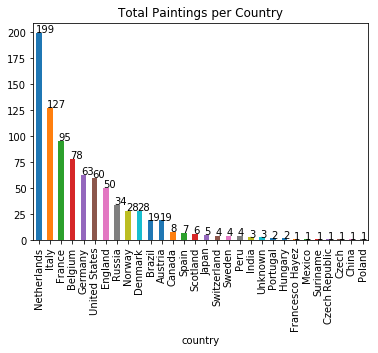

In [17]:
#Count of paintings per country
country_count = paintings_df.groupby('country').size().sort_values(ascending=False)
ax = country_count.plot.bar(title='Total Paintings per Country')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

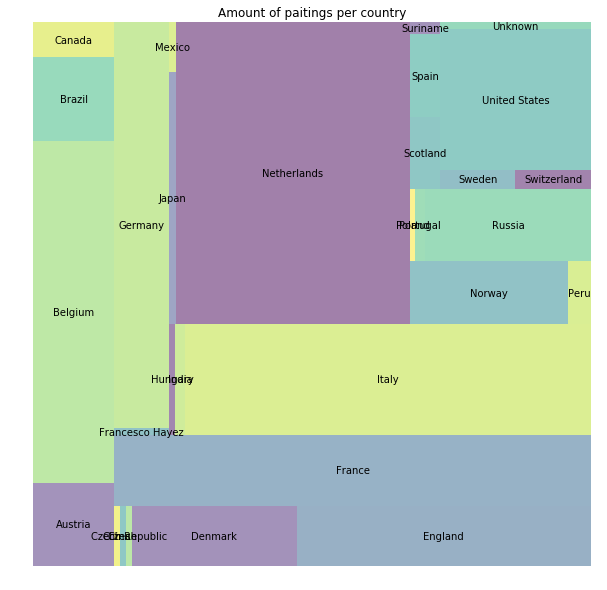

In [20]:
# Squareplot for countries
x = list(paintings_df.groupby('country').size().index)
y = paintings_df.groupby('country').size().values

dims = (10, 10)
plt.subplots(figsize = dims)

squarify.plot(sizes=y, label=x, alpha=.5 )
plt.axis('off')
plt.title('Amount of paitings per country')
plt.show()

In [21]:
# List the countries with a minimum number of paintings
country_most_artworks = country_count[0]
min_paintings_per_country = country_most_artworks*0.08
top_countries = set(country_count[country_count.values > min_paintings_per_country].index)

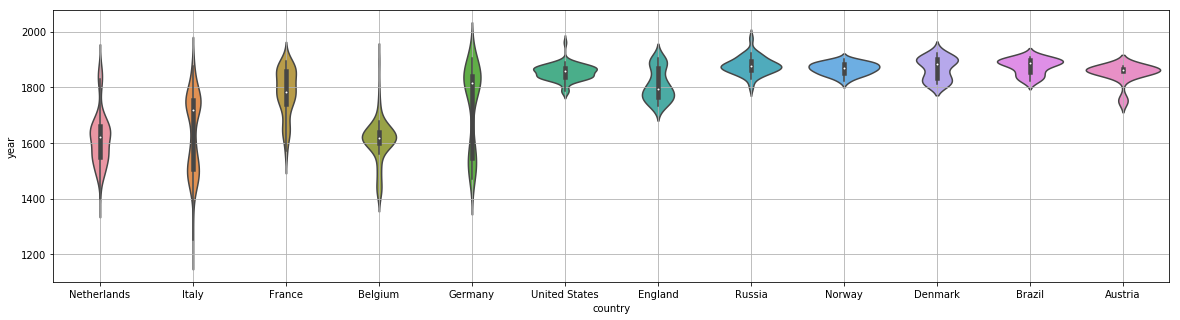

In [22]:
# Violin plot - Top Countries
dims = (20, 5)
plt.subplots(figsize = dims)

order = [x for x in list(country_count.index) if x in list(top_countries)]

sns.violinplot(x=paintings_df[paintings_df['country'].isin(top_countries)].country
               , y=pd.to_numeric(paintings_df[paintings_df['country'].isin(top_countries)].year)
               , title='Top Countries vs Year'
               , order=order)
plt.grid()
plt.show()

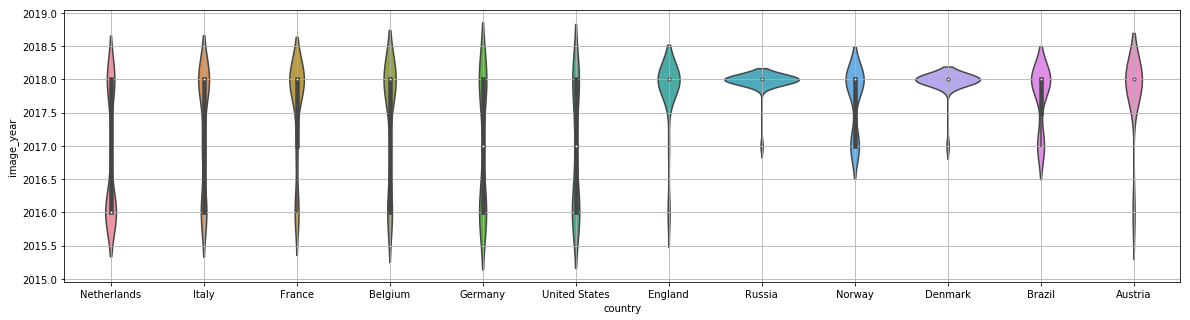

In [23]:
# Violin plot - Top Countries
dims = (20, 5)
plt.subplots(figsize = dims)

order = [x for x in list(country_count.index) if x in list(top_countries)]

sns.violinplot(x=paintings_df[paintings_df['country'].isin(top_countries)].country
               , y=paintings_df[paintings_df['country'].isin(top_countries)].image_year.astype(int)
               , title='Top Countries vs Year'
               , order=order
               , )
plt.grid()
plt.show()

In [24]:
country_summary = paintings_df.groupby('country') \
       .agg({'year':'mean'
            ,'artwork':'nunique'
            ,'artist':'nunique'}) \
       .rename(columns={'year':'mean_year'
                       ,'artwork':'n_paintings'
                       ,'artist':'n_artists'
                       }) \
       .reset_index()
country_summary.sort_values(by='n_paintings',ascending=False).head(5)

,country,mean_year,n_paintings,n_artists
17,Netherlands,1619.281407,193,97
14,Italy,1639.283465,126,49
9,France,1779.684211,93,42
1,Belgium,1609.025641,77,29
11,Germany,1736.079365,63,29


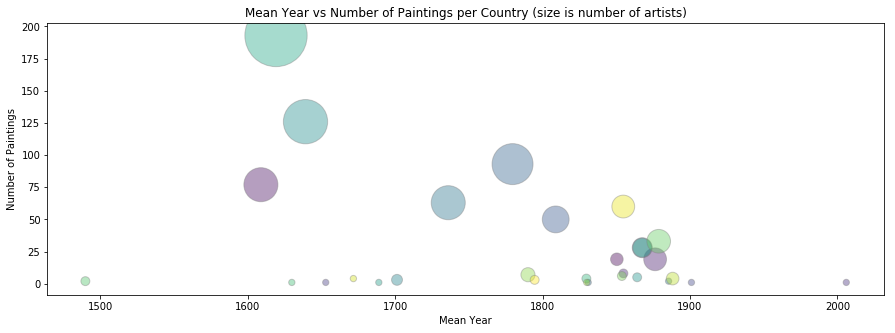

In [25]:
dims = (15, 5)
plt.subplots(figsize = dims)

x = country_summary['mean_year'] # year
y = country_summary['n_paintings']  # number of paintings
z = country_summary['n_artists']  # number of artists
#z = x+np.random.rand(15)
#z = z*z
z = z/50
#z = .1

# Set colors per country
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(country_summary['country'])))

# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y
            , s=z*2000
            #, c=x
            , c=colors
            #, c=artist_summary['country']
            , cmap="Blues"
            , alpha=0.4
            , edgecolors="grey"
            , linewidth=1)

# Add titles (main and on axis)
plt.xlabel("Mean Year")
plt.ylabel("Number of Paintings")
plt.title("Mean Year vs Number of Paintings per Country (size is number of artists)")

# Add country name 
# add color legend

plt.show()

# Artists

In [26]:
# Count and Average year per artist
artist_summary = paintings_df.groupby(['artist','country']) \
       .agg({'artwork':'size'
             ,'year':'min'
             ,'year':'max'
             ,'year':'mean'}) \
       .rename(columns={'artwork':'n_paintings'
                        ,'year':'mean_year'
                        ,'year':'mean_year'
                        ,'year':'mean_year'}) \
       .reset_index()
#artist_summary[artist_summary.country =='Netherlands'].sort_values(by='n_paintings',ascending=False).head(25)

# Add amount of year artist was working

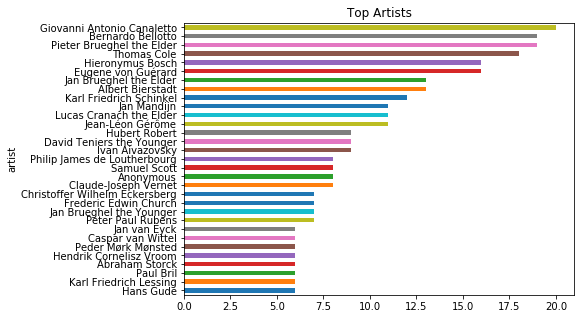

In [27]:
# List the artists with a minimun count of paintings
artist_count = paintings_df.groupby('artist').size()

min_paintings_per_artist = 5
top_artists = set(artist_count[artist_count.values > min_paintings_per_artist].index)


#print(artist_count.sort_values(ascending=False))
#print(top_artists)
dims = (7, 5)

plt.subplots(figsize = dims)
artist_count[top_artists].sort_values(ascending=True).plot.barh(title='Top Artists')

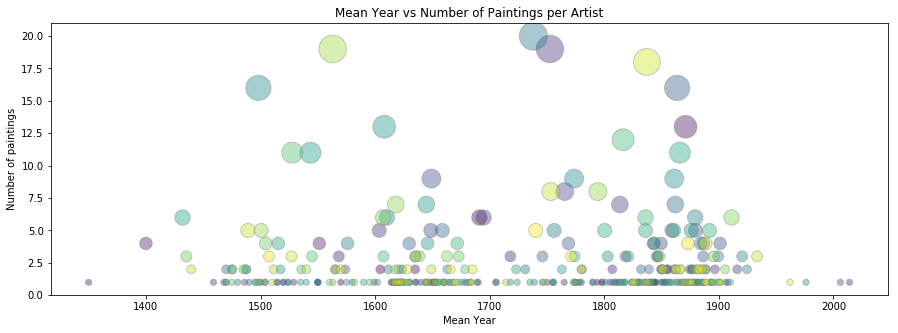

In [29]:
dims = (15, 5)
plt.subplots(figsize = dims)

x = artist_summary['mean_year'] # year
y = artist_summary['n_paintings']  # number of paintings
z = artist_summary['n_paintings']  # number of paintings
#z = x+np.random.rand(15)
#z = z*z
z = z/50
#z = .1

# Set colors per country
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(artist_summary['country'])))

# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y
            , s=z*2000
            #, c=x
            , c=colors
            #, c=artist_summary['country']
            , cmap="Blues"
            , alpha=0.4
            , edgecolors="grey"
            , linewidth=1)

# for i, txt in enumerate(artist_summary['artist']):
#     ax.annotate(txt, (z[i],y[i]))
    
# for i in range(len(artist_summary['artist'])):
#     x = points[i][0]
#     y = points[i][1]
#     plt.plot(x, y, 'bo')
#     plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
# Add titles (main and on axis)
plt.xlabel("Mean Year")
plt.ylabel("Number of paintings")
plt.title("Mean Year vs Number of Paintings per Artist")

# add color legend
# add text for artist (each circle)

plt.show()

# Years

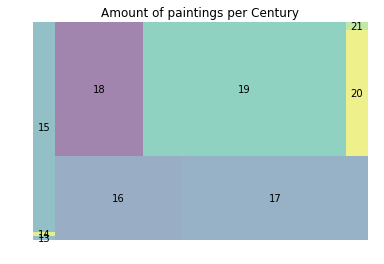

In [30]:
# Squareplot for centuries
x = list(paintings_df.groupby('century').size().index)
y = paintings_df.groupby('century').size().values

squarify.plot(sizes=y, label=x, alpha=.5 )
plt.axis('off')
plt.title('Amount of paintings per Century')
plt.show()

In [19]:
# Count and Average year per century
artist_summary = paintings_df.groupby(['artist','country']) \
       .agg({'artwork':'size'
            ,'year':'mean'}) \
       .rename(columns={'artwork':'n_paintings'
                       ,'year':'mean_year'}) \
       .reset_index()
artist_summary.sort_values(by='n_paintings',ascending=False).head(5)

,artist,country,n_paintings,mean_year
128,Giovanni Antonio Canaletto,Italy,20,1738.150000
46,Bernardo Bellotto,Italy,19,1752.578947
278,Pieter Brueghel the Elder,Netherlands,19,1563.000000
299,Thomas Cole,United States,18,1837.111111
153,Hieronymus Bosch,Netherlands,16,1498.125000


In [31]:
# Count and Average year per period
period_summary = paintings_df.groupby(['century','period']) \
       .agg({'artwork':'nunique'
            ,'artist':'nunique'
            ,'year':'mean'}) \
       .rename(columns={'artwork':'n_paintings'
                       ,'artist':'n_artists'
                       ,'year':'mean_year'}) \
       .reset_index()
min_paintings = 1
period_summary['period_order'] = pd.Categorical(period_summary['period'], ["Early", "Mid", "Late"])
period_summary.sort_values(by=(['century','period_order']))[period_summary['n_paintings'] > min_paintings]

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


,century,period,n_paintings,n_artists,mean_year,period_order
2,15,Early,5,3,1422.000000,Early
4,15,Mid,11,5,1443.272727,Mid
3,15,Late,37,22,1484.631579,Late
5,16,Early,51,23,1515.773585,Early
7,16,Mid,46,19,1554.297872,Mid
6,16,Late,25,19,1582.920000,Late
8,17,Early,82,46,1617.333333,Early
10,17,Mid,67,41,1650.671642,Mid
9,17,Late,32,20,1680.156250,Late
11,18,Early,26,12,1719.038462,Early


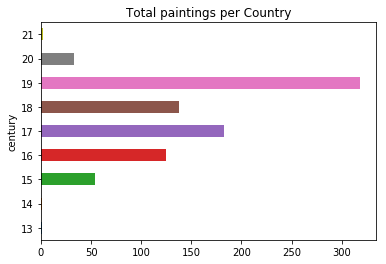

In [32]:
# List the centuries with a minimun count of paintings
century_count = paintings_df.groupby('century').size()
min_paintings_per_century = 40
top_centuries = set(century_count[century_count.values > min_paintings_per_century].index)
#print(century_count)
#print(top_centuries)
century_count.plot.barh(title='Total paintings per Country')

# Image dimensions

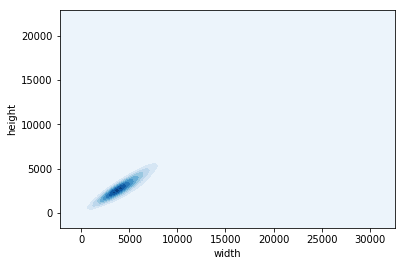

In [33]:
# Density of image dimensions
sns.kdeplot(paintings_df.width, paintings_df.height, cmap="Blues", shade=True, shade_lowest=True)

In [34]:
print('Actual mean width: ' , paintings_df.width.mean())
print('Actual mean height: ' , paintings_df.height.mean())
resize_perc = 0.5
print('If we want to make the images smaller for the model by ' + str(resize_perc*100) + '%')
print('Smaller mean width: ' , paintings_df.width.mean()*resize_perc)
print('Smaller mean height: ' , paintings_df.height.mean()*resize_perc)

Actual mean width:  4732.079532163742
Actual mean height:  3288.3426900584795
If we want to make the images smaller for the model by 50.0%
Smaller mean width:  2366.039766081871
Smaller mean height:  1644.1713450292398


# Collection additions per time

In [ ]:
paintings_df.groupby('image_date').size()


In [ ]:
paintings_df['obj1_count'] = (df['object'] == 'obj1').cumsum()

In [ ]:
paintings_df.groupby(paintings_df.image_month).cumsum().reset_index()

In [35]:
paintings_df.groupby(['image_year','image_month']).size()
#paintings_df.groupby(['image_year','image_month']).plot.barh()

image_year  image_month
2016        1              204
            3                1
            5                1
            6               42
2017        4                1
            10              77
            11               2
2018        1                2
            2                1
            3              112
            4              261
            5              117
            7               14
            8                2
            11               4
            12              14
dtype: int64

# Data prep - Predict Century

to follow: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py


In [ ]:
# Subset original DF, pick up only big enough centuries
train_df = paintings_df[paintings_df.century.isin(top_centuries)]
#print(paintings_df.groupby('century').size())
#print(train_df.groupby('century').size())
#train_df.shape

In [ ]:
classes = set(train_df.century)
num_classes = len(classes)

#train_path='training_data'
train_path = train_df.image_path

# validation split
validation_size = 0.2

# batch size
batch_size = 16

data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)